# Dogs vs Cats Image Classification

In this project, we aim to build a machine learning model able of classifying images with dogs and cats. This report can be divided in four steps:

* Getting and setting up the data
* Training the model
* Testing the model
* Conclusion
* Offtopic

## Getting and setting up the data

We start our project by loading the necessary packages and getting some general information about the data. We are going to be using the tensorflow dataset "cats_vs_dogs".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
from skimage.transform import resize

tfds.disable_progress_bar()

builder = tfds.builder('cats_vs_dogs')
info = builder.info

info


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path=PosixGPath('/tmp/tmpl9cpurgktfds'),
    file_format=tfrecord,
    download_size=786.68 MiB,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},


We have 23262 samples. Each sample contains an image, a filename and a label. The image has 3 channels, which indicates that it is in a simple RGB format. Since we do not have any information about width and height, we can assume that the images can have different dimensions. Let us import and divide the data into three datasets: train, validation and test. 

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


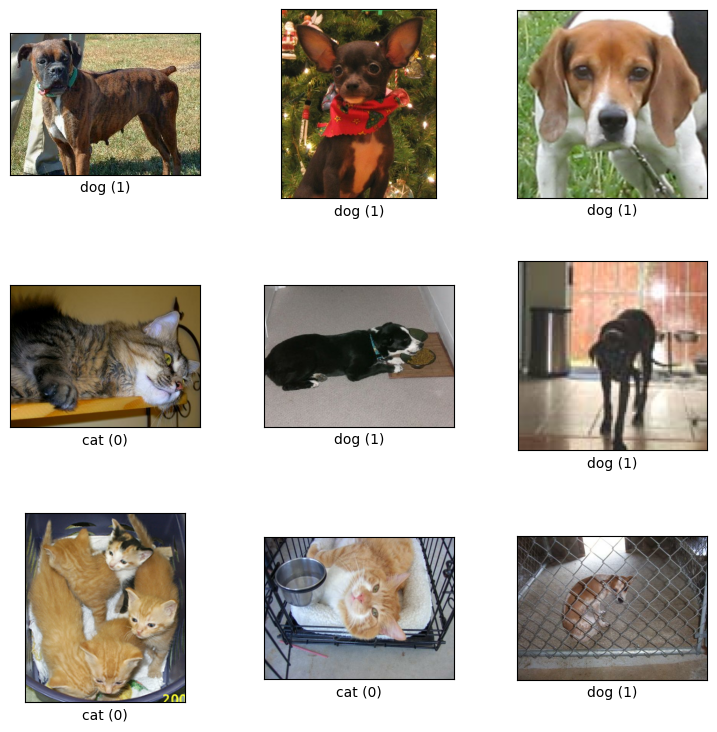

In [2]:
split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']

train_ds, val_ds, test_ds = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)

fig = tfds.show_examples(train_ds, info)

By looking at the images above, we can already see that they indeed can have different dimensions, as we expected. Since in this project we intend to use neural networks, we must have images with the same dimensions. To keep things simple, we are going to set the images dimensions to a default value and see how it works. We are going to perform this using batches of 32.

In [4]:
HEIGHT = 200
WIDTH = 200
def change_dimensions(img, label):
    return tf.image.resize(img, [HEIGHT, WIDTH]), label

train_ds = train_ds.map(change_dimensions).batch(32)
val_ds = val_ds.map(change_dimensions).batch(32)
test_ds = test_ds.map(change_dimensions).batch(32)

## Training the model

Let us start building our model. First, we are rescaling the data, since neural networks work better with numbers between 0 and 1. To keep things simple, we are going to start using Dense layers. We will use Relu as our activation function for all layers (with the exception of the last layer, that must use a sigmoid function, since we will use a binary cross entropy as our loss function) and accurary as our evaluation metric. We are going to use 10 epochs to train the model. If theres no improvement from one epoch to another, the training will be stopped.

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model = keras.Sequential([
  keras.layers.Rescaling(1./255,input_shape=(HEIGHT, WIDTH, 3)), 
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Dense(32, activation='relu'),
  keras.layers.Flatten(),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 51s 76ms/step - loss: 0.9596 - accuracy: 0.6318 - val_loss: 0.6076 - val_accuracy: 0.6702
Epoch 2/10
582/582 [==============================] - 52s 89ms/step - loss: 0.6092 - accuracy: 0.6669 - val_loss: 0.6283 - val_accuracy: 0.6582
Epoch 3/10
582/582 [==============================] - 56s 95ms/step - loss: 0.5930 - accuracy: 0.6836 - val_loss: 0.6331 - val_accuracy: 0.6612
Epoch 4/10
582/582 [==============================] - 49s 84ms/step - loss: 0.5818 - accuracy: 0.6977 - val_loss: 0.6593 - val_accuracy: 0.6380
Epoch 5/10
582/582 [==============================] - 44s 75ms/step - loss: 0.5561 - accuracy: 0.7181 - val_loss: 0.6839 - val_accuracy: 0.6294
Epoch 6/10
582/582 [==============================] - 44s 76ms/step - loss: 0.5375 - accuracy: 0.7305 - val_loss: 0.7174 - val_accuracy: 0.6234
Epoch 7/10
582/582 [==============================] - 43s 74ms/step - loss: 0.5157 - accuracy: 0.7499 - val_loss: 0.7333 - val_accuracy:

We have got an accuracy below 63% in the validation dataset. Let us see how the training and validation evolved together.

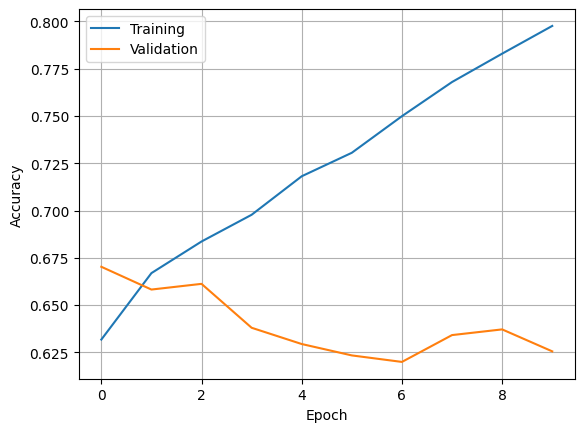

In [ ]:
plt.plot(trainHistory.history['accuracy'])
plt.plot(trainHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

As the training accuracy increased, the validation decreased. This indicates that the model may be overfitting to the training data. Now let us try a convolutional approach. We start with a more standard model, with convolutional layers intercalated with pooling layers, ending with a dense layer. Depending on the results, we are going to dive more into the theory to get better results.

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 44s 62ms/step - loss: 0.6134 - accuracy: 0.6657 - val_loss: 0.5645 - val_accuracy: 0.6900
Epoch 2/10
582/582 [==============================] - 38s 66ms/step - loss: 0.4850 - accuracy: 0.7672 - val_loss: 0.4977 - val_accuracy: 0.7592
Epoch 3/10
582/582 [==============================] - 42s 71ms/step - loss: 0.4012 - accuracy: 0.8161 - val_loss: 0.4802 - val_accuracy: 0.7747
Epoch 4/10
582/582 [==============================] - 37s 63ms/step - loss: 0.3073 - accuracy: 0.8678 - val_loss: 0.5154 - val_accuracy: 0.7872
Epoch 5/10
582/582 [==============================] - 37s 63ms/step - loss: 0.2232 - accuracy: 0.9078 - val_loss: 0.6437 - val_accuracy: 0.7653
Epoch 6/10
582/582 [==============================] - 34s 59ms/step - loss: 0.1692 - accuracy: 0.9329 - val_loss: 0.7651 - val_accuracy: 0.7605
Epoch 7/10
582/582 [==============================] - 35s 59ms/step - loss: 0.1271 - accuracy: 0.9516 - val_loss: 0.7888 - val_accuracy:

We have got an accuracy of almost 77% in the validation data. Let us see again how the training and validation accuracies evolved together.

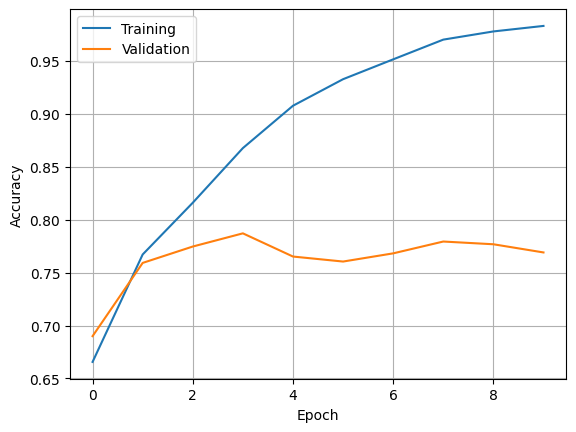

In [ ]:
plt.plot(trainHistory.history['accuracy'])
plt.plot(trainHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()

The model started to overfit after three epochs. We are now going to use three different architectures and compare their results. The architectures are:

* LeNet-5
* AlexNet
* VGG-16

They are better explained [here](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d).

Let us start with the LeNet-5 architecture.

In [ ]:
model_lenet = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
  keras.layers.Conv2D(6, 5,  activation='tanh'),
  keras.layers.AveragePooling2D(2),
  keras.layers.Conv2D(16, 5,  activation='tanh'),
  keras.layers.AveragePooling2D(2),
  keras.layers.Flatten(),
  keras.layers.Dense(120, activation='tanh'),
  keras.layers.Dense(84, activation='tanh'),
  keras.layers.Dense(1, activation='sigmoid')
])

model_lenet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory_lenet = model_lenet.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 36s 58ms/step - loss: 0.7204 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5185
Epoch 2/10
582/582 [==============================] - 38s 66ms/step - loss: 0.6951 - accuracy: 0.5039 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 3/10
582/582 [==============================] - 37s 64ms/step - loss: 0.6949 - accuracy: 0.5046 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 4/10
582/582 [==============================] - 40s 69ms/step - loss: 0.6948 - accuracy: 0.5037 - val_loss: 0.6929 - val_accuracy: 0.5185
Epoch 5/10
582/582 [==============================] - 38s 66ms/step - loss: 0.6947 - accuracy: 0.5037 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 6/10
582/582 [==============================] - 36s 62ms/step - loss: 0.6947 - accuracy: 0.5048 - val_loss: 0.6928 - val_accuracy: 0.5185
Epoch 7/10
582/582 [==============================] - 37s 63ms/step - loss: 0.6947 - accuracy: 0.5053 - val_loss: 0.6928 - val_accuracy:

51.85% of accuracy, almost a random guess. Now let us try the AlexNet architecture. We are also changing the early stopping monitor to val_loss

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)
model_alexnet = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
  keras.layers.Conv2D(96, 11, strides=4, activation='relu'),
  keras.layers.MaxPooling2D(3, strides=2),
  keras.layers.Conv2D(256, 5, strides=1, activation='relu'),
  keras.layers.MaxPooling2D(3, strides=2),
  keras.layers.Conv2D(384, 3, strides=1, activation='relu'),
  keras.layers.Conv2D(384, 3, strides=1, activation='relu'),
  keras.layers.Conv2D(256, 3, strides=1, activation='relu'),
  keras.layers.MaxPooling2D(3, strides=2),
  keras.layers.Flatten(),
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(1, activation='sigmoid')
])

model_alexnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory_alexnet = model_alexnet.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 40s 60ms/step - loss: 0.6939 - accuracy: 0.5010 - val_loss: 0.6938 - val_accuracy: 0.4815
Epoch 2/10
582/582 [==============================] - 36s 62ms/step - loss: 0.6933 - accuracy: 0.5011 - val_loss: 0.6936 - val_accuracy: 0.4815
Epoch 3/10
582/582 [==============================] - 37s 64ms/step - loss: 0.6933 - accuracy: 0.5019 - val_loss: 0.6938 - val_accuracy: 0.4815


We actually have gotten worse. Let us try the VGG-16 architecture.

In [ ]:
model_vgg = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
  keras.layers.Conv2D(64, 3, padding ='same', activation='relu'),
  keras.layers.Conv2D(64, 3, padding ='same', activation='relu'),
  keras.layers.MaxPooling2D(2, strides=2, padding ='same'),
  keras.layers.Conv2D(128, 3, padding ='same', activation='relu'),
  keras.layers.Conv2D(128, 3, padding ='same', activation='relu'),
  keras.layers.MaxPooling2D(2, strides=2, padding ='same'),
  keras.layers.Conv2D(256, 3, padding ='same', activation='relu'),
  keras.layers.Conv2D(256, 3, padding ='same', activation='relu'),
  keras.layers.MaxPooling2D(2, strides=2, padding ='same'),
  keras.layers.Conv2D(512, 3, padding ='same', activation='relu'),
  keras.layers.Conv2D(512, 3, padding ='same', activation='relu'),
  keras.layers.MaxPooling2D(2, strides=2, padding ='same'),
  keras.layers.Conv2D(512, 3, padding ='same', activation='relu'),
  keras.layers.Conv2D(512, 3, padding ='same', activation='relu'),
  keras.layers.MaxPooling2D(2, strides=2, padding ='same'),
  keras.layers.Flatten(),
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dense(4096, activation='relu'),
  keras.layers.Dense(1000, activation='softmax'),
  keras.layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory_vgg = model_vgg.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 208s 327ms/step - loss: 0.6933 - accuracy: 0.5021 - val_loss: 0.6939 - val_accuracy: 0.4815
Epoch 2/10
582/582 [==============================] - 176s 302ms/step - loss: 0.6932 - accuracy: 0.5032 - val_loss: 0.6937 - val_accuracy: 0.4815
Epoch 3/10
582/582 [==============================] - 176s 302ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6936 - val_accuracy: 0.4815
Epoch 4/10
582/582 [==============================] - 176s 303ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6936 - val_accuracy: 0.4815
Epoch 5/10
582/582 [==============================] - 176s 302ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6936 - val_accuracy: 0.4815
Epoch 6/10
582/582 [==============================] - 180s 309ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6936 - val_accuracy: 0.4815
Epoch 7/10
582/582 [==============================] - 175s 301ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6936 -

Well... theory has failed us! Let us try to improve a little bit our first convolutional model and train it again with our new early stopping function. Let us start using more dense layers.

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(256, activation='relu'),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 37s 59ms/step - loss: 0.6035 - accuracy: 0.6571 - val_loss: 0.5369 - val_accuracy: 0.7403
Epoch 2/10
582/582 [==============================] - 35s 60ms/step - loss: 0.4967 - accuracy: 0.7528 - val_loss: 0.5065 - val_accuracy: 0.7567
Epoch 3/10
582/582 [==============================] - 35s 60ms/step - loss: 0.4056 - accuracy: 0.8119 - val_loss: 0.5347 - val_accuracy: 0.7377
Epoch 4/10
582/582 [==============================] - 34s 58ms/step - loss: 0.3102 - accuracy: 0.8641 - val_loss: 0.6405 - val_accuracy: 0.7046
Epoch 5/10
582/582 [==============================] - 34s 58ms/step - loss: 0.2270 - accuracy: 0.9043 - val_loss: 0.6616 - val_accuracy: 0.7601
Epoch 6/10
582/582 [==============================] - 36s 63ms/step - loss: 0.1540 - accuracy: 0.9399 - val_loss: 0.9630 - val_accuracy: 0.7549
Epoch 7/10
582/582 [==============================] - 33s 57ms/step - loss: 0.1079 - accuracy: 0.9605 - val_loss: 1.1298 - val_accuracy:

Now let us try using more convolutional layers, instead of dense layers.

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255, input_shape=(HEIGHT, WIDTH, 3)),
  keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
trainHistory = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[callback])

Epoch 1/10
582/582 [==============================] - 39s 63ms/step - loss: 0.6233 - accuracy: 0.6379 - val_loss: 0.5339 - val_accuracy: 0.7519
Epoch 2/10
582/582 [==============================] - 35s 60ms/step - loss: 0.4988 - accuracy: 0.7553 - val_loss: 0.4912 - val_accuracy: 0.7635
Epoch 3/10
582/582 [==============================] - 33s 56ms/step - loss: 0.4128 - accuracy: 0.8106 - val_loss: 0.4060 - val_accuracy: 0.8190
Epoch 4/10
582/582 [==============================] - 33s 57ms/step - loss: 0.3434 - accuracy: 0.8496 - val_loss: 0.3850 - val_accuracy: 0.8328
Epoch 5/10
582/582 [==============================] - 34s 58ms/step - loss: 0.2751 - accuracy: 0.8851 - val_loss: 0.4070 - val_accuracy: 0.8255
Epoch 6/10
582/582 [==============================] - 33s 56ms/step - loss: 0.2189 - accuracy: 0.9105 - val_loss: 0.4897 - val_accuracy: 0.8121
Epoch 7/10
582/582 [==============================] - 34s 58ms/step - loss: 0.1799 - accuracy: 0.9273 - val_loss: 0.6368 - val_accuracy:

We ended up with an accuracy of almost 82%. Let us save the model and finish the training.


In [ ]:
model.save('/content/drive/MyDrive/Data Science/model.h5')

## Testing the model

Let us now evaluate our model with the test dataset.

In [5]:
model = keras.models.load_model('/content/drive/MyDrive/Data Science/model.h5')
model.evaluate(test_ds)

73/73 [==============================] - 22s 300ms/step - loss: 0.9519 - accuracy: 0.8177


[0.9519357681274414, 0.8177127838134766]

We have got the same accuracy as of our validation dataset. Now let us see the classifier in practice.

10/10 [==============================] - 0s 18ms/step


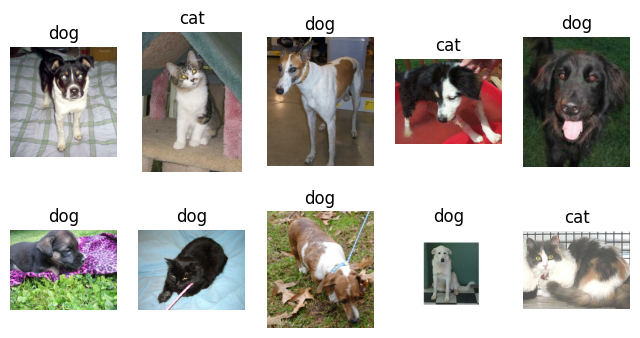

In [31]:
examples = tfds.load(name='cats_vs_dogs', split='train[99%:]', as_supervised=True)

examples_processed = examples.map(change_dimensions).batch(1)
classNames = ['cat', 'dog']
predictions = model.predict(examples_processed.take(10))
i = 0
fig, ax = plt.subplots(2, 5, figsize=(8,4))
for image, _ in examples.take(10):
    predictedLabel = int(predictions[i] >= 0.5)

    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].set_title(classNames[predictedLabel])
    ax[i//5,i%5].imshow(image)
    i += 1

plt.show()

8 out of 10, very close to the accuracy in the test dataset. Now let us try testing the model with some external data. First we will import a dog picture.

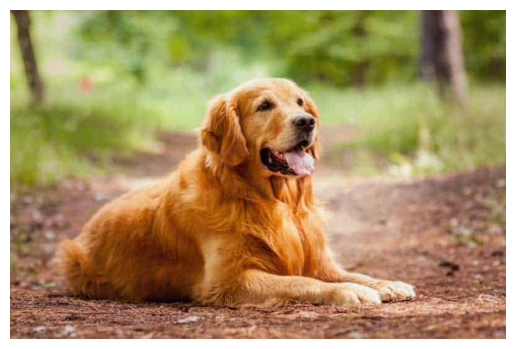

In [36]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://www.petz.com.br/blog/wp-content/uploads/2019/05/cachorro-independente-1.jpg")
img = Image.open(BytesIO(response.content))
plt.axis('off')
plt.imshow(img)
plt.show()

Now let us classify it.

1/1 [==============================] - 0s 26ms/step


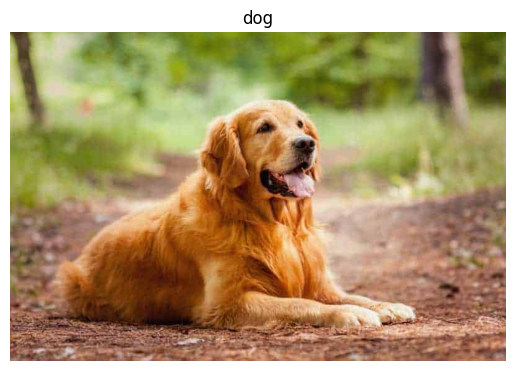

In [43]:
dog = tf.convert_to_tensor(img)
dog = tf.image.resize(dog, [HEIGHT, WIDTH])
dog = np.expand_dims(dog, axis=0)
label = classNames[int(model.predict(dog) >= 0.5)]
plt.axis('off')
plt.title(label)
plt.imshow(img)
plt.show() 

We got it! Now let us do the same with a cat picture.

1/1 [==============================] - 0s 43ms/step


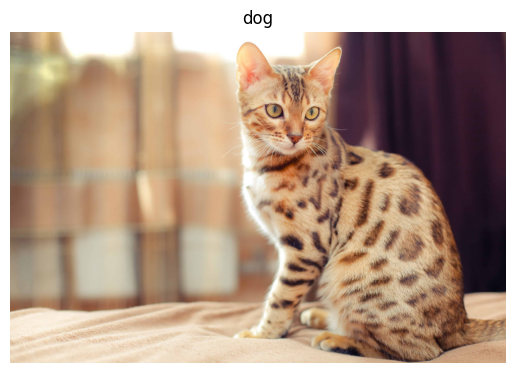

In [45]:
response = requests.get("https://www.petz.com.br/blog/wp-content/uploads/2015/06/shutterstock_175064507.jpg")
img = Image.open(BytesIO(response.content))
cat = tf.convert_to_tensor(img)
cat = tf.image.resize(cat, [HEIGHT, WIDTH])
cat = np.expand_dims(cat, axis=0)
label = classNames[int(model.predict(cat) >= 0.5)]
plt.axis('off')
plt.title(label)
plt.imshow(img)
plt.show() 

Something tells me that this dog is not going to bark. Let us try another one.

1/1 [==============================] - 0s 46ms/step


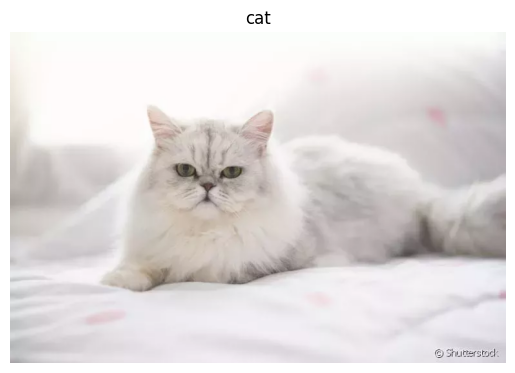

In [49]:
response = requests.get("https://www.patasdacasa.com.br/sites/patasdacasa/files/styles/webp/public/noticias/2022/04/gato-persa-tudo-que-voce-precisa-saber-sobre-a-personalidade-da-raca.jpg.webp?itok=95EBZXum")
img = Image.open(BytesIO(response.content))
cat = tf.convert_to_tensor(img)
cat = tf.image.resize(cat, [HEIGHT, WIDTH])
cat = np.expand_dims(cat, axis=0)
label = classNames[int(model.predict(cat) >= 0.5)]
plt.axis('off')
plt.title(label)
plt.imshow(img)
plt.show() 